In [1]:
import torch
import torch.nn as nn

In [2]:
class ImageClassification(nn.Module):

    def train_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss': loss.detach(), 'val_acc': acc}


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [3]:


class HairModelClassification(ImageClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=(2, 2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),

            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),

            # layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=(2,2), stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.5),

            # Last layer
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, xb):
        return self.network(xb)

In [4]:
texture_model = torch.load('/texture_model.pth')
color_model = torch.load('/color_model.pth')

In [5]:
from PIL import Image
from torchvision import transforms

def test_image_from_path(path, model, labels):
  test_transform = transforms.Compose([
      transforms.Resize((128, 128)),               # Resize the image to 128x128
      transforms.RandomHorizontalFlip(p=0.2),      # Random horizontal flip with probability 0.2
      transforms.ToTensor()                        # Convert the image to a PyTorch tensor
  ])

  # Load your specific test image
  test_image = Image.open(path)  # Replace "path_to_your_test_image.jpg" with the path to your test image
  test_image = test_transform(test_image)  # Apply transformations

  # Ensure the model is in evaluation mode
  model.eval()

  # Forward pass the test image through the model
  with torch.no_grad():
      output = model(test_image.unsqueeze(0))  # Add a batch dimension

  # Get the predicted class
  _, predicted_class = torch.max(output, 1)

  # Print the predicted class
  return labels[predicted_class.item()]

In [6]:
import urllib.request
from io import BytesIO

def test_image_from_url(url, model, labels):
  test_transform = transforms.Compose([
      transforms.Resize((128, 128)),               # Resize the image to 128x128
      transforms.RandomHorizontalFlip(p=0.2),      # Random horizontal flip with probability 0.2
      transforms.ToTensor()                        # Convert the image to a PyTorch tensor
  ])

  with urllib.request.urlopen(url) as url:
    test_image = Image.open(BytesIO(url.read()))  # Replace "path_to_your_test_image.jpg" with the path to your test image
  test_image = test_transform(test_image)  # Apply transformations

  # Ensure the model is in evaluation mode
  model.eval()

  # Forward pass the test image through the model
  with torch.no_grad():
      output = model(test_image.unsqueeze(0))  # Add a batch dimension

  # Get the predicted class
  _, predicted_class = torch.max(output, 1)

  # Print the predicted class
  return labels[predicted_class.item()]

In [7]:
texture_labels = ["curly", "straight", "wavy"]
color_labels = ["black", "brown", "blond"]

In [8]:
shampoos = {
 ("curly", "blond"): "Tahe Magic Rizos – Szampon fioletowy, nawilżający do pielęgnacji włosów kręconych blond",
 ("curly", "brown"): "Ajurwedyjski szampon w kostce do włosów kręconych SHIKAKAI",
 ("curly", "black"): "CHI Curly Care Curl - odżywczy szampon do włosów kręconych",

 ("wavy", "black"): "Oryginalny piwny szampon do włosów Saela",
 ("wavy", "brown"): "Szampon PERFECT HAIR DAY firmy LIVING PROOF",
 ("wavy", "blond"): "Z.one Milk_Shake Icy Blond szampon do włosów z czarnym pigmentem",

 ("straight", "black"): "Biacre Shine Szampon z olejem lnianym nadający połysk",
 ("straight", "brown"): "Montibello, Treat NaturTech, Brown Reflect, Shampoo",
 ("straight", "blond"): "CHI – MAGNIFIED VOLUME SHAMPOO",
}

In [9]:
shampoos_urls = {
 ("curly", "blond"): "https://bellita.pl/img/imagecache/5001-6000/500x500/product-media/5001-6000/Tahe-Magic-Rizos-VIOLET-LOW-POO-SHAMPOO-Curl-300-5147-500x500-nobckgr.webp",
 ("curly", "brown"): "https://encrypted-tbn3.gstatic.com/shopping?q=tbn:ANd9GcTRH0GGKRehC_bhEP9ePhNMDY1lZBK9cvdrs9qmtGgR5GHyur2XqifJ_5VBL6jaae9MPEPIIA-NzQch5LJVQ5VohyT6x7lsCzHdjexn2Bln6orJOxviBGjj&usqp=CAc",
 ("curly", "black"): "https://encrypted-tbn3.gstatic.com/shopping?q=tbn:ANd9GcRhsS-HI6WFDhF3NEBE4Rtb1RJNIq2TBKAKqrLK_Zt5DCXO_4X473iN3ixDjezDW-_zqlgwNkP1FvF4EyqaedOpaW2ygmhZRIdkJF2ZDXDYc0cpPJZPBReI8MDjGC8xMEMFdwXoJtKnS5g&usqp=CAc",

 ("wavy", "black"): "https://static2.mintishop.pl/pol_pm_Saela-Oryginalny-piwny-szampon-do-wlosow-300-ml-29298_1.webp",
 ("wavy", "brown"): "https://static.thcdn.com/images/large/original//productimg/1600/1600/11907768-1754930873472277.jpg",
 ("wavy", "blond"): "https://fryzjersklep.pl/pol_pl_Z-one-Milk_Shake-NOWOSC-Icy-Blond-szampon-300ml-8759_1.jpg",

 ("straight", "black"): "https://hairlook.pl/userdata/public/gfx/11541/Shampoo-250.jpg",
 ("straight", "brown"): "https://image.ceneostatic.pl/data/products/38462791/i-montibello-treat-naturtech-colour-reflect-nt-brazowy-300ml.jpg",
 ("straight", "blond"): "https://kosmetykiata.pl/wp-content/uploads/2021/10/CHI-MAGNIFIED-VOLUME-SHAMPOO-SZAMPON-ZWIEKSZAJACY-OBJETOSC-946-ml.png",
}

In [10]:
shampoos_desc = {
 ("curly", "blond"): "Szampon odpowiedni dla włosów kręconych, równoważący pomarańczowe tony",
 ("curly", "brown"): "Szampon w kostce do kręconych włosów z dodatkiem indyjskiego proszku shikakai. Przeznaczony dla włosów ciemnych.",
 ("curly", "black"): "Szampon do włosów kręconych, skupiający się na zwiększaniu miękkości i gładkości.",

 ("wavy", "black"): "Szampon wzmacniający strukturę włosa i zwiększający obiętość. Działa pozytywnie dla skóry głowy.",
 ("wavy", "brown"): "Szampon profesjonalny, przeznaczony do wszystkich rodzajów brązowych włosów.",
 ("wavy", "blond"): "Szampon z czarnym i fioletowym pigmentem. Fioletowy pigment Neutralizuje żółte i pomarańczowe tony, a czarny przepięknie schładza nadając popielatego, chromatycznego odcienia włosom blond.",

 ("straight", "black"): "Szampon z olejem lnianym nadający połysk oraz elastyczność włosom.",
 ("straight", "brown"): "Szampon do włosów w odcieniach brązu, który natychmiast uwydatnia i odświeża kolor, a także dodaje blasku już po pierwszym użyciu. Szampon chroni przed promieniowaniem słonecznym, delikatnie myje i sprawia, że wyrazisty kolor wlosów utrzymuje się znacznie dłużej.",
 ("straight", "blond"): "Fioletowy szampon zwiększający objętość, równocześnie chroniąc włosy.",
}

In [11]:
import urllib.request
from io import BytesIO

def display_from_url(url):
  with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))
  display(img)

In [12]:
def get_recomendations(path):
  hair_texture = test_image_from_path(path, texture_model, texture_labels)
  hair_color = test_image_from_path(path, color_model, color_labels)
  key = (hair_texture, hair_color)
  print(shampoos[key])
  display_from_url(shampoos_urls[key])
  print(shampoos_desc[key])

In [13]:
def get_recomendations_from_url(url):
  hair_texture = test_image_from_url(url, texture_model, texture_labels)
  hair_color = test_image_from_url(url, color_model, color_labels)
  key = (hair_texture, hair_color)
  print(shampoos[key])
  display_from_url(shampoos_urls[key])
  print(shampoos_desc[key])

Szampon PERFECT HAIR DAY firmy LIVING PROOF


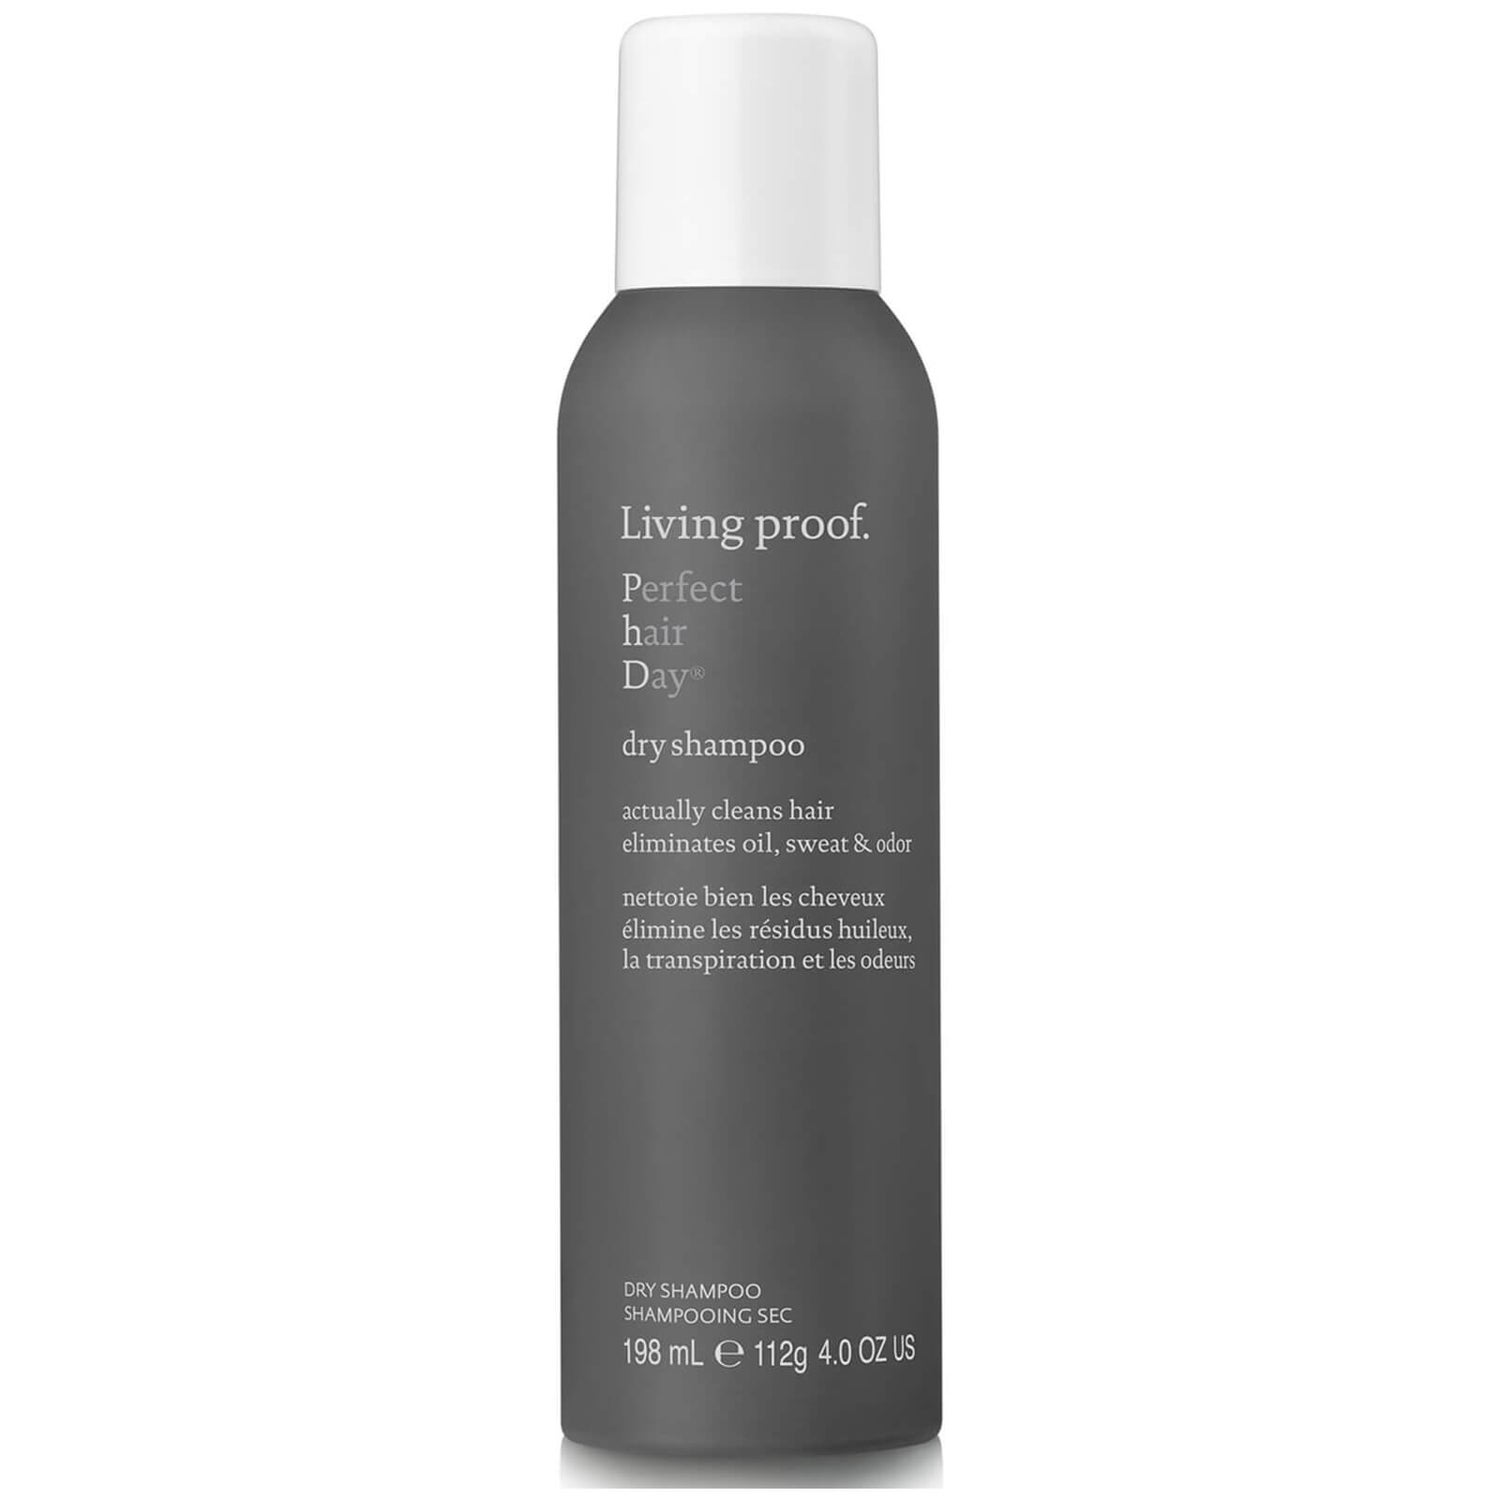

In [14]:
get_recomendations_from_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTGBtzrdIMz-8y-kntiXJ5Osz34Y7tAa3ucCoWg0cZ4eQ&s")
